# Least Significant Bit Demonstration

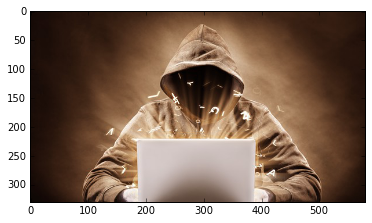

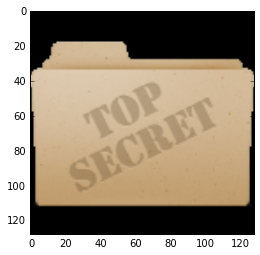

In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

coverimg = cv2.imread('hacker.jpg')
plt.imshow(coverimg)
plt.show()

msgimg = cv2.imread('topsecret.png')
plt.imshow(msgimg)
plt.show()

In [2]:
# Set the i-th bit of byte to value
def setbit(byte, i, value):
    # remove the original i-th bit of byte
    mask = ~ (1 << i)
    newbyte = byte & mask
    # set value
    if value:
        newbyte |= ~mask
    return newbyte

# Embeds two bits of a message in a cover byte
def embedbyte(coverbyte, bits):
    firstbit = bits[0]
    secondbit = bits[1]
    stegobyte = setbit(coverbyte, 0, firstbit)
    stegobyte = setbit(stegobyte, 1, secondbit)
    return stegobyte

# Embeds message bits into a 2D cover array
def embed2D(coverarray, msgbitsoriginal):
    msgbits = msgbitsoriginal.copy()
    stegoarray = coverarray.copy()
    for rowindex in range(0, len(coverarray)):
        for columnindex in range(0, len(coverarray[rowindex])):
            # Return if there are no more bits left to embed
            if not msgbits:
                return stegoarray
            
            firstbit = msgbits.pop(0)
            if msgbits:
                secondbit = msgbits.pop(0)
            else:
                secondbit = 0b0
            bits = [firstbit, secondbit]
            value = coverarray[rowindex][columnindex]
            stegovalue = embedbyte(value, bits)
            stegoarray[rowindex][columnindex] = stegovalue
            
def embed3D(coverarray, msgbitsoriginal):
    msgbits = msgbitsoriginal.copy()
    stegoarray = coverarray.copy()
    for rowindex in range(0, len(coverarray)):
        for columnindex in range(0, len(coverarray[rowindex])):
            for layerindex in range(0, len(coverarray[rowindex][columnindex])):
                # Return if there are no more bits left to embed
                if not msgbits:
                    return stegoarray
                
                firstbit = msgbits.pop(0)
                if msgbits:
                    secondbit = msgbits.pop(0)
                else:
                    secondbit = 0b0
                bits = [firstbit, secondbit]
                value = coverarray[rowindex][columnindex][layerindex]
                stegovalue = embedbyte(value, bits)
                stegoarray[rowindex][columnindex][layerindex] = stegovalue

# Example of embed2D altering an array
msgbits = [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]
msglength = len(msgbits)
redplane = coverimg[:, :, 0]
# Only displaying the first entries to shorten output
print(redplane[0][:20])
stegoarray2D = embed2D(redplane, msgbits)
print(stegoarray2D[0][:20])
print((redplane == stegoarray2D)[0][:20])

[21 21 21 22 22 21 21 21 22 23 23 23 23 24 24 24 25 25 25 25]
[21 22 23 20 22 21 22 22 23 22 23 23 23 24 24 24 25 25 25 25]
[ True False False False  True  True False False False False  True  True
  True  True  True  True  True  True  True  True]


In [3]:
# Example of embed3D altering an array
msgbits = [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]
msglength = len(msgbits)
# Only displaying the first entries to shorten output
print(coverimg[0][:5])
stegoarray3D = embed3D(coverimg, msgbits)
print(stegoarray3D[0][:5])
print((coverimg == stegoarray3D)[0][:5])


[[21 10  6]
 [21 10  6]
 [21 10  6]
 [22 11  7]
 [22 11  7]]
[[21 10  7]
 [20 10  5]
 [22 10  7]
 [22 11  7]
 [22 11  7]]
[[ True  True False]
 [False  True False]
 [False  True False]
 [ True  True  True]
 [ True  True  True]]


In [4]:
# Reads the last two bits of a byte
def readbits(byte):
    firstbit = byte & 0b1
    secondbit = byte >> 1 & 0b1
    return [firstbit, secondbit]

# Extracts hidden bits from a 3D array
def extract3D(stegoarray, msglength):
    msgbits = []
    for rowindex in range(0, len(stegoarray)):
        for columnindex in range(0, len(stegoarray[rowindex])):
            for layerindex in range(0, len(stegoarray[rowindex][columnindex])):
                # Return if there are no more bits left to extract
                if len(msgbits) >= msglength:
                    return msgbits
                                
                value = stegoarray[rowindex][columnindex][layerindex]
                bits = readbits(value)
                msgbits.append(bits[0])
                if len(msgbits) < msglength:
                    msgbits.append(bits[1])
                    
extractedmsg = extract3D(stegoarray3D, msglength)
print(extractedmsg)
print(msgbits == extractedmsg)

[1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]
True


Cover image


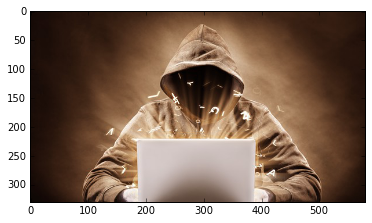

Stego image


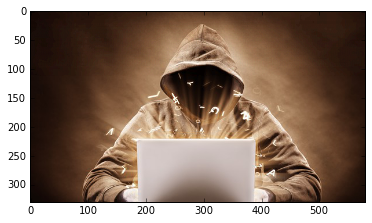

Hidden image


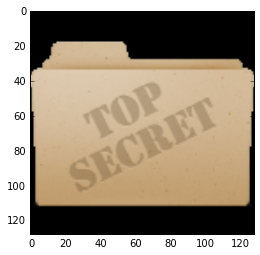

In [5]:
def deconstructbyte(byte):
    bits = []
    for i in range(0, 8):
        bits.append(byte & 0b1)
        byte >>= 1
    return bits

def reconstructbyte(bits):
    byte = 0
    for i in range(len(bits)-1, -1, -1):
        byte <<= 1
        byte |= bits[i]
    return byte

def deconstructimg(imgmatrix):
    bits = []
    for row in imgmatrix:
        for column in row:
            for value in column:
                deconstruction = deconstructbyte(value)
                for bit in deconstruction:
                    bits.append(bit)
    return bits

def reconstructimg(bits, dimensions):
    height, width = dimensions
    imgmatrix = np.zeros((height, width, 3), dtype=np.uint8)
    for rowindex in range(0, height):
        for columnindex in range(0, width):
            for layerindex in range(0, 3):
                valuebits = []
                for i in range(0, 8):
                    valuebits.append(bits.pop(0))
                value = reconstructbyte(valuebits)
                imgmatrix[rowindex][columnindex][layerindex] = value
    return imgmatrix

# Embed and extract
msgimgbits = deconstructimg(msgimg)
stegoimg = embed3D(coverimg, msgimgbits)
extractedimgbits = extract3D(stegoimg, len(msgimgbits))
extractedimg = reconstructimg(extractedimgbits, (msgimg.shape[0], msgimg.shape[1]))

print("Cover image")
plt.imshow(coverimg)
plt.show()
print("Stego image")
plt.imshow(stegoimg)
plt.show()
print("Hidden image")
plt.imshow(extractedimg)
plt.show()

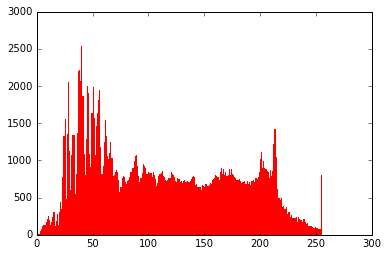

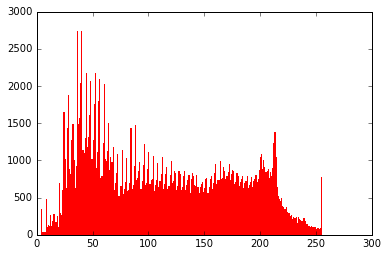

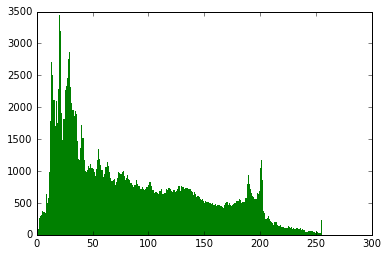

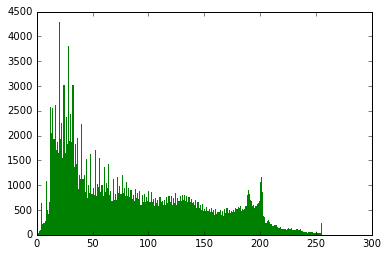

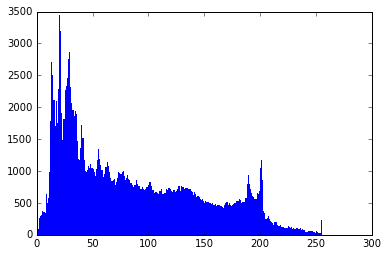

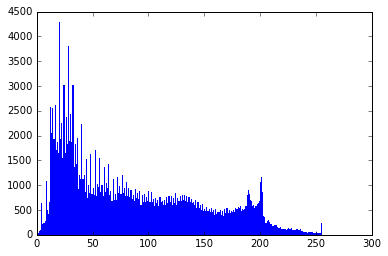

In [6]:
bins = []
for n in range(0, 257):
    bins.append(n)
width = 1
leftborders = bins[:-1]

# Red plane
coverhistred = np.histogram(coverimg[:,:,0], bins=bins)[0]
plt.bar(leftborders, coverhistred, width=width, linewidth=0, color='r')
plt.show()
stegohistred = np.histogram(stegoimg[:,:,0], bins=bins)[0]
plt.bar(leftborders, stegohistred, width=width, linewidth=0, color='r')
plt.show()

# Green plane
coverhistgreen = np.histogram(coverimg[:,:,1], bins=bins)[0]
plt.bar(leftborders, coverhistgreen, width=width, linewidth=0, color='g')
plt.show()
stegohistgreen = np.histogram(stegoimg[:,:,1], bins=bins)[0]
plt.bar(leftborders, stegohistgreen, width=width, linewidth=0, color='g')
plt.show()

# Blue plane
coverhistblue = np.histogram(coverimg[:,:,1], bins=bins)[0]
plt.bar(leftborders, coverhistblue, width=width, linewidth=0, color='b')
plt.show()
stegohistblue = np.histogram(stegoimg[:,:,1], bins=bins)[0]
plt.bar(leftborders, stegohistblue, width=width, linewidth=0, color='b')
plt.show()